In [3]:
# use streetsmart env
import requests
import time
import shapely
from shapely.geometry import Polygon, LineString, Point, MultiPoint, MultiPolygon
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import ast
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
import geopandas as gpd
import json
import cv2
import pickle
import os

# print in format without using 10e
np.set_printoptions(suppress = True)

# MODEL NOT INCLUDED DUE TO LINCENSE RESTRICTIONS

## Extract images with Streetsmart API

Steps for each wall:
* get best camera id and position for this wall
* (check if actually visible or whether buildings are in the way)
* compute yaw, pitch and hfov for camera position to wall
* compute image coordinates for all corners of wall from real-world wall coordinates
* save all metadata of image and image coordinates of all corners in seperate file
* rectify wall (change order with point above?)
* save images

### Set global variables and load data

In [4]:
# important paths
data_dir = "./../../data"
image_dir = data_dir + "/images"
dataframes_dir = data_dir + "/dataframes"


## Cyclomedia parameters

# fill in user name and password for cyclomedia login here
user_name = ''
user_pwd = ''
auth = (user_name, user_pwd)

# fill in api key here
cyclo_api_key = ''

global_base_url = 'https://atlas.cyclomedia.com/PanoramaRendering/'

# srs
#gk_srs = 'EPSG:25833'
gk_srs = 'EPSG:55567837'
webmercator_srs = '4326'
cyclo_srs = '55567837' # for render-surface: epsg in front!

# other params
camera_height = 2.09
img_width, img_height = 1024, 768

In [4]:
# read data in
df1_parts = pd.read_csv(dataframes_dir + "/df1_parts.csv")
df2_walls = pd.read_csv(dataframes_dir + "/df2_walls_02_all_lod_factors.csv")

df1_parts["ground_surface"] = df1_parts["ground_surface"].apply(ast.literal_eval)
df2_walls["surface_coordinates"] = df2_walls["surface_coordinates"].apply(ast.literal_eval)
df2_walls["normal_vec"] = df2_walls["normal_vec"].apply(ast.literal_eval)
df2_walls["outside_surface_coordinates"] = df2_walls["outside_surface_coordinates"].apply(ast.literal_eval)
df2_walls["outside_bounding_box"] = df2_walls["outside_bounding_box"].apply(ast.literal_eval)

df2_walls

,part_id,wall_id,surface_coordinates,area,normal_vec,wall_height,angle_to_north,cardinal_direction,outside_surface_coordinates,outside_area,outside_subtracted_walls,outside,outside_groundbound,outside_bounding_box
0,DESN_000WFP8_main,UUID_0bbcf935-b8f5-49d6-8931-af23caaa2903,"[(311035.68, 5688001.348, 123.998), (311030.45...",23.453131,"[0.21849090832257181, -0.9758389841466559, 0.0]",4.376,167.379588,south,"[[(311035.68, 5688001.348, 119.622), (311030.4...",0.021438,['UUID_3d057299-6871-46e5-9ce5-a6f5673412ef'],False,True,"[(311035.68, 5688001.348, 119.626), (311030.45..."
1,DESN_000WFP8_main,UUID_d94fd64c-53e3-4563-9fe1-3a9b840fb214,"[(311030.45, 5688000.177, 123.998), (311028.45...",30.821034,"[-0.9743074935930067, -0.22522190818948584, 0.0]",4.376,256.984072,east,"[[(311030.45, 5688000.177, 123.998), (311028.4...",30.821034,[],True,True,"[(311030.45, 5688000.177, 123.998), (311028.45..."
2,DESN_000WFP8_main,UUID_78e9d3b0-4fdd-4fe2-94fe-06ce701ffa86,"[(311028.453, 5688008.816, 122.198), (311033.6...",13.683157,"[-0.20407453903918482, 0.9789553526672932, 0.0]",2.576,348.224671,north,"[[(311028.453, 5688008.816, 122.198), (311033....",13.683157,[],True,True,"[(311028.453, 5688008.816, 122.198), (311033.6..."
3,DESN_000WFP8_main,UUID_41f1c6a6-8857-4ce3-b0f5-3eb1aaa5bc54,"[(311033.653, 5688009.9, 122.198), (311035.68,...",30.550349,"[0.973041327471674, 0.2306308197794957, 0.0]",4.376,76.665786,west,"[[(311033.653, 5688009.9, 122.198), (311035.68...",30.550349,[],True,True,"[(311033.653, 5688009.9, 123.998), (311035.68,..."
4,DESN_1389772836945_13701754,UUID_465e5cc3-707b-48e4-a7ee-81a03a9e2ee6,"[(311036.776, 5687996.602, 124.441), (311031.5...",25.802259,"[0.2170292510132926, -0.9761651008946228, 0.0]",4.815,167.465394,south,"[[(311036.776, 5687996.602, 124.441), (311031....",25.802259,[],True,True,"[(311036.776, 5687996.602, 124.441), (311031.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921477,DESN_{FFEE841E-E7EB-40A8-B30D-A6D687B1F3E1}_main,combined_148030,"[(313850.567, 5696064.5, 134.154), (313850.567...",21.854214,"[-0.3771581149334625, -0.9261488845427809, 0.0]",2.274,202.157760,south,"[[(313850.567, 5696064.5, 136.428), (313851.83...",3.495069,['fme-gen-96bcba7e-1644-4f94-83c4-78c9255c4fd7'],False,True,"[(313859.468, 5696060.875, 136.428), (313850.5..."
921478,DESN_{FFF09CB1-4832-4013-BCA0-B171BB394B1D}_main,combined_148031,"[(311382.012, 5696641.969, 125.313), (311383.2...",9.705224,"[-0.9554153043036776, 0.2952652981681242, 0.0]",2.747,287.173446,east,"[[(311382.012, 5696641.969, 125.313), (311383....",9.705224,[],True,True,"[(311382.012, 5696641.969, 128.06), (311383.20..."
921479,DESN_{FFF09CB1-4832-4013-BCA0-B171BB394B1D}_main,combined_148032,"[(311388.235, 5696644.284, 125.313), (311387.0...",9.705224,"[0.9554153043036776, -0.2952652981681242, 0.0]",2.747,107.173446,west,"[[(311388.235, 5696644.284, 125.313), (311387....",9.705224,[],True,True,"[(311388.235, 5696644.284, 128.06), (311387.03..."
921480,DESN_{FFF313F9-F3A1-4760-8F91-9C9A4B7F261B}_main,combined_148033,"[(310549.938, 5691404.49, 114.324), (310549.93...",28.322057,"[-0.9848609099134684, 0.17334643960697627, 0.0]",2.746,279.982445,east,"[[(310549.938, 5691404.49, 114.324), (310549.9...",28.322057,[],True,True,"[(310548.15, 5691394.332, 117.07), (310549.938..."


### Filter for all walls that we want to extract images from

In [ ]:
# 1. we only want outside walls (at least 50% of their area is facing exterior and not covered by other buildings) and walls of which the outside part is also ground bound -> column outside and outside_groundbound ; outside_area should be at least 10m²

# make new variable whether wall is technically interesting to take an image from (factors above)
df2_walls["interesting_for_image"] = True
df2_walls.loc[~df2_walls["outside"], "interesting_for_image"] = False
df2_walls.loc[~df2_walls["outside_groundbound"], "interesting_for_image"] = False
df2_walls.loc[df2_walls["outside_area"] < 20, "interesting_for_image"] = False

# check how many outside surfaces that are divided in several parts are fulfilling above requirements
print("outside surfaces that are split:", df2_walls[np.array([len(outside_surf) for outside_surf in df2_walls["outside_surface_coordinates"]]) > 1].value_counts("interesting_for_image"))
# not enough so that its worth it to take them into account for programming
df2_walls.loc[np.array([len(outside_surf) for outside_surf in df2_walls["outside_surface_coordinates"]]) > 1, "interesting_for_image"] = False

df2_walls.value_counts("interesting_for_image")

outside surfaces that are split: interesting_for_image
False    7402
True     1051
Name: count, dtype: int64


interesting_for_image
True     698884
False    222598
Name: count, dtype: int64

In [6]:
# either make new, empty dictionary with camera ids and their coordinates, or read one in if it already exists
read_in_existing_dict = True

if read_in_existing_dict:
    with open(dataframes_dir + '/dict_camera_ids.json', 'r') as json_file:
        dict_camera_ids = json.load(json_file)
else:
    dict_camera_ids = {}

In [ ]:
def get_angle_0_to_180(vec1, vec2):
    '''
    Takes two vectors (2d or 3d) and computes the angle in degrees between both. Order of the vectors does not matter

    ARGS:
    * vec1, vec2 (2d or 3d tuples): vectors between which the angle should be calculated

    RETURNS:
    * angle in degrees between 0 and 180°
    '''
    a_norm = vec1 / np.linalg.norm(vec1)
    b_norm = vec2 / np.linalg.norm(vec2)
    
    # Calculate the dot product
    dot_product = np.dot(a_norm, b_norm)

    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle_radians = np.arccos(dot_product)
    
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees


def get_horizontal_angle_to_north(vec1):
    '''
    Calculates the horizontal angle to the north from a given 2D vector

    PARAMS:
    * vec1 (numpy.ndarray or list): A 2D vector represented as a list or numpy array with two components (x, y), where x is the east-west component and y is the north-south component.

    RETURNS:
    * float: The angle in degrees from north (0 degrees) to the direction of the vector, measured clockwise.
    '''

    angle_degrees = get_angle_0_to_180(vec1, np.array([0,1]))

    # if east-value is negative, the yaw is higher than 180 degrees (the angle computed here does not care about the direction though), hence the computed angle needs to be subtracted from 360°
    if vec1[0] < 0:
        angle_degrees = 360-angle_degrees
    
    return angle_degrees



def get_camera_coordinates_from_id(camera_id):
    '''
    Retrieves the 3D coordinates of a camera based on its ID

    PARAMS:
    * camera_id (str): The unique identifier for the camera whose coordinates are to be retrieved.

    RETURNS:
    * list: A list containing the 3D coordinates of the camera in the format [X, Y, Z] if the request is successful or None if the request fails or the camera ID is invalid.
    '''
    # make render request (no matter in which view direction) to get metadata
    request_url = global_base_url + 'Render/' + camera_id + '/?apiKey=' + cyclo_api_key + '&srsName=' + gk_srs
    response = requests.get(url=request_url, auth=auth)

    if response.status_code == 200:
        meta_data = response.headers
        # extract and return camera coords
        return list([float(meta_data["RecordingLocation-X"]), float(meta_data["RecordingLocation-Y"]), float(meta_data["RecordingLocation-Z"])])
    else:
        #print("status code", response.status_code)
        return None 
    
    
def check_first_x_recordings_for_visibility(recordings_xml, corners_on_ground, normal_wall, df1_parts_gdf, x = 10, dist_limit = 50):
    '''
    Checks the visibility of a wall from the first x recordings based on camera positions and viewing directions.

    This function iterates through a specified number of recordings to determine if the wall is visible from
    the cameras associated with those recordings. It checks the angle of the camera's viewing direction relative
    to the wall's normal and ensures that the camera is within a certain distance from the midpoint of the wall and that the field of view is free from buildings.

    PARAMS:
    * recordings_xml (list): A list of XML elements representing the recordings, each containing the attributes "recording-id" and "viewing-direction".
    * corners_on_ground (list of tuple): A list of tuples representing the coordinates of the corners of the wall that are on the ground.
    * normal_wall (tuple): A tuple representing the normal vector of the wall.
    * df1_parts_gdf (GeoDataFrame): A GeoDataFrame all buildings and parts, used for visibility check
    * x (int, optional): The maximum number of recordings to check for visibility. Default is 10.
    * dist_limit (float, optional): The maximum distance from the wall's midpoint for a camera to be considered. Default is 50.

    RETURNS:
    * bool: True if the wall is visible from any of the checked cameras, False otherwise.
    * str or int: The camera ID if the wall is visible, or 0 if it is not visible or if the camera is too far away or has a wrong angle
    '''

    # if there are less than x recording_ids found close to the wall, only check the found ones
    limit = min(x, len(recordings_xml))
    # midpoint of wall
    middle_of_wall = np.mean(np.array(corners_on_ground), axis = 0)

    for recording in recordings_xml[:limit]:
        # check whether surface is visible from camera
        # get camera coordinates
        camera_id = recording.attrib["recording-id"]
        # check if angle fits
        viewing_dir = float(recording.attrib["viewing-direction"]) # viewing dir of camera to midpoint
        if viewing_dir < 0:
            viewing_dir = 360 + viewing_dir
        # get angle of wall normal to north
        normal_to_north = get_horizontal_angle_to_north(normal_wall[:2])
        # absolute angle between normal and viewing dir should be between 120 and 240°
        angle = np.abs((normal_to_north - viewing_dir))
        if angle > 180:
            angle = 360-angle

        if angle > 120:
            # angle is fine, extract camera coordinates (either dict or with render call) 
            if camera_id in dict_camera_ids.keys():
                camera_position = dict_camera_ids[camera_id]
            else:
                camera_position = get_camera_coordinates_from_id(camera_id)
                dict_camera_ids[camera_id] = camera_position
            if camera_position is not None:
                # check distance
                dist = shapely.distance(Point((camera_position[0], camera_position[1])), Point(middle_of_wall))
                if dist < dist_limit:
                    # check whether field of view is free
                    visible = visible_from_camera(camera_position, corners_on_ground, df1_parts_gdf)

                    if visible:
                        return True, camera_id
                    
                else:
                    return False, 0 # if this camera is already too far away, the next one will be as well

    return False, 0


def visible_from_camera(camera_position, corners_on_ground, df1_parts_gdf):
    '''
    Determines if a wall is visible from a given camera position by checking if the line of sight from the camera to the wall is obstructed by any building parts.
    It creates a polygon that spans from the camera position to the corners of the wall on the ground and checks for intersections with the geometries of building parts. If any part intersects with more than 5% of the polygon's area, the wall is considered not visible.

    PARAMS:
    * camera_position (tuple): A tuple representing the (x, y, z) coordinates of the camera position, z not needed though
    * corners_on_ground (list of 2d tuple): A list of tuples representing the coordinates of the corners of the wall on the ground.
    * df1_parts_gdf (GeoDataFrame): A GeoDataFrame containing the geometries of building parts to check for visibility.

    RETURNS:
    * bool: True if the wall is visible from the camera position, False if it is obstructed by building parts.
    '''

    # span polygon between all corners of wall that are on the ground (should be at least two) and the camera point
    camera_to_wall_polygon = Polygon([(camera_position[0], camera_position[1])] + corners_on_ground + [(camera_position[0], camera_position[1])]).buffer(0)

    if camera_to_wall_polygon.area <= 0:
        return False

    # search for all building parts intersecting with this polygon
    intersecting_parts = df1_parts_gdf[df1_parts_gdf.geometry.intersects(camera_to_wall_polygon)]

    # look if any part intersects with more than 5% of the polygons area
    for ind, row_intersecting_part in intersecting_parts.iterrows():
        intersection = camera_to_wall_polygon.intersection(row_intersecting_part["ground_surface"])
        if isinstance(intersection, Polygon) or isinstance(intersection, MultiPolygon):
            # look if area is bigger then 5% of the area between camera and wall, in this case return False directly
            if (intersection.area / camera_to_wall_polygon.area) > 0.05:
                return False
        # if the intersection is not a line or a point, return false as well as not sure what is happening here
        elif not isinstance(intersection, LineString) and not isinstance(intersection, Point) and not isinstance(intersection, MultiPoint):
            return False
        
    return True


In [ ]:
# make column for camera id
df2_walls["camera_id_for_image"] = "not_searched_for"

# make geo-df containing df1 and df2 info, with ground surface as geometry
df1_df2_join = pd.merge(df2_walls, df1_parts, how = "left", on = "part_id")
df1_parts_temp = df1_parts.copy()
# buffer ground surface to correct some small inaccuracies in data
df1_parts_temp.loc[:,"ground_surface"] = [Polygon(ground_surface).buffer(0) for ground_surface in df1_parts_temp["ground_surface"]]
df1_parts_gdf = gpd.GeoDataFrame(df1_parts_temp, geometry = "ground_surface")

In [ ]:
# runs for 3350mins -> 56h
start_time = time.time()
for index, row in df1_df2_join.iterrows():

    if index%25000 == 0:
        print(index, "/", len(df1_df2_join))
        # Save dictionary to file
        with open(dataframes_dir + '/dict_camera_ids.json', 'w') as json_file:
            json.dump(dict_camera_ids, json_file)
        # save intermediate result to file
        df2_walls.to_csv(dataframes_dir + "/df2_walls_all_factors_with_camera_id_intermediate.csv", index = False)

    # for each row that camera id was not searched for (if taking an intermediate step) and is interesting
    if row["interesting_for_image"] and row["camera_id_for_image"] == "not_searched_for":
        # get x/y coordinates of the middle of the wall on ground (2d, ignore z)
        corners_on_ground = []
        ground_min = np.min(np.array(row["ground_surface"])[:,2]) - 0.1
        ground_max = np.max(np.array(row["ground_surface"])[:,2]) + 0.1
        for corner in row["surface_coordinates"][:-1]:
            if corner[2] < ground_max and corner[2] > ground_min:
                corners_on_ground.append(corner[:2])

        middle_of_wall = np.mean(np.array(corners_on_ground), axis = 0)
        if len(middle_of_wall) == 2:
            # get closest camera positions to this middle point of the wall
            request_url = global_base_url + 'ListByLocation2D/' + cyclo_srs + '/' + str(middle_of_wall[0]) + '/' + str(middle_of_wall[1]) + '?apiKey=' + cyclo_api_key
            response = requests.get(url=request_url, auth=auth)

            # if this was successfull, go through first x cameras included in response and see if they are suitable
            # (suitable: angle not more than 60° different from orthogonal view, distance less than 30m, not too much of view is obstructed)
            if response.status_code == 200:
                recordings_xml = ET.fromstring(response.text)
                #print(len(recordings_xml))
                check_successfull, camera_id = check_first_x_recordings_for_visibility(recordings_xml,
                                                                                    corners_on_ground,
                                                                                    row["normal_vec"],
                                                                                    df1_parts_gdf, x = 10,
                                                                                    dist_limit = 30)
                if check_successfull:
                    df2_walls.at[index, "camera_id_for_image"] = camera_id
                else:
                    df2_walls.at[index, "camera_id_for_image"] = "none_found"

            else:
                df2_walls.at[index, "camera_id_for_image"] = "none_found"
        else:
            df2_walls.at[index, "camera_id_for_image"] = "none_found"
        
print(time.time() - start_time, "seconds")

0 / 921482
25000 / 921482
50000 / 921482
75000 / 921482
100000 / 921482
125000 / 921482
150000 / 921482
175000 / 921482
200000 / 921482
225000 / 921482
250000 / 921482
275000 / 921482
300000 / 921482
325000 / 921482
350000 / 921482
375000 / 921482
400000 / 921482
425000 / 921482
450000 / 921482
475000 / 921482
500000 / 921482
525000 / 921482
550000 / 921482
575000 / 921482
600000 / 921482
625000 / 921482
650000 / 921482
675000 / 921482
700000 / 921482
725000 / 921482
750000 / 921482
775000 / 921482
800000 / 921482
825000 / 921482
850000 / 921482
875000 / 921482
900000 / 921482
200844.40315008163 seconds


In [6]:
print("camera_id is not found for", len(df2_walls[df2_walls["camera_id_for_image"] == "none_found"]), "walls, found for", len(df2_walls[~df2_walls["camera_id_for_image"].isin(["none_found", "not_searched_for"])]), "walls")
print("and not searched for", len(df2_walls[df2_walls["camera_id_for_image"] == "not_searched_for"]))

camera_id is not found for 496235 walls, found for 202649 walls
and not searched for 222598


In [16]:
# Save dictionary and df2 to file
with open(dataframes_dir + '/dict_camera_ids.json', 'w') as json_file:
    json.dump(dict_camera_ids, json_file)

df2_walls.to_csv(dataframes_dir + "/df2_walls_03_with_camera_id.csv", index = False)

In [ ]:
df2_walls

### Compute yaw, pitch and hfov for camera position to wall

In [24]:
# example wall is:
example_wall = df2_walls[~df2_walls["camera_id_for_image"].isin(["none_found", "not_searched_for"])].iloc[1]
example_image_path = image_dir + "/example_image.jpg"

In [17]:
# get_horizontal_angle_to_north already defined above

def get_vertical_angle(vec1):
    '''
    Calculates the pitch: the vertical angle from a given 2D vector to the horizontal plane

    PARAMS:
    * vec1 (numpy.ndarray or list): A 2D vector represented as a list or numpy array with two components (x, y), where x is the east-west component and y is the north-south component.

    RETURNS:
    * float: The angle in degrees from the vector to the horizontal plane, positive if camera is looking up, negative else
    '''

    # vector to which the angle is measured is the same angle as the input, but z is 0 (makes it horizontal)
    a_norm = vec1 / np.linalg.norm(vec1)
    vec2 = np.array([vec1[0], vec1[1], 0])
    b_norm = vec2 / np.linalg.norm(vec2)
    
    # Calculate the dot product
    dot_product = np.dot(a_norm, b_norm)
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle_radians = np.arccos(dot_product)
    
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)

    # if height-value is negative, the pitch is lower than 0 degrees, the angle needs to be negative then
    if vec1[2] < 0:
        angle_degrees = -angle_degrees
    
    return angle_degrees


def get_camera_parameters(wall, camera_coordinates):
    ''' 
    For a given rectangle (defined by its corners) and camera coordinates, this function calculates the yaw, horizontal field of view (hfov), and pitch required to capture the entire rectangle.

    PARAMS:
    * wall: list of coordinate tuples, bounding box and therefore starting with upper right corner
    * camera_coordinates: A 3d tuple representing the coordinates of the camera.

    RESULTS:
    * yaw: The horizontal angle of the camera around the vertical axis (in degrees).
    * hfov: The horizontal field of view of the camera (in degrees).
    * pitch: The vertical angle of the camera around the horizontal axis (in degrees).
    
    Returns None for yaw, hfov, and pitch if any calculated values are out of the expected bounds.
    '''

    wall = np.array(wall)
    camera_coordinates = np.array(camera_coordinates)

    # get angle to top edge of wall and low edge
    v_angle_top = np.max([get_vertical_angle(wall[0] - camera_coordinates), get_vertical_angle(wall[1] - camera_coordinates)])
    v_angle_bot = np.min([get_vertical_angle(wall[2] - camera_coordinates), get_vertical_angle(wall[3] - camera_coordinates)])

    # middle of this is pitch
    pitch = np.mean([v_angle_top, v_angle_bot])

    # get angle to north for both left and right coordinates of walls -
    # -> these need to be inside [yaw - Hfov/2, yaw + Hfov/2]
    # Hence: yaw will be middle angle of those
    h_angle_left = get_horizontal_angle_to_north(wall[1,:2] - camera_coordinates[:2])
    h_angle_right = get_horizontal_angle_to_north(wall[0,:2] - camera_coordinates[:2])

    # if right side of the building is slightly east of the north axis (y) and left side is west 
    # # (e.g. angle_right is 10, angle left is 330)
    if h_angle_right - h_angle_left < 0: 
        yaw = (h_angle_right - (360-h_angle_left))/2
        if yaw < 0:
            yaw = 360+yaw
        hfov = ((h_angle_right + (360-h_angle_left)) * 1.1) *((2/10000) * pitch**2 + 1) # always 10% more and correct for higher pitch
    else:
        yaw = np.mean([h_angle_right, h_angle_left])
        hfov = ((h_angle_right - h_angle_left) * 1.1) * ((2/10000) * pitch**2 + 1) # always 10% more and correct for higher pitch
    
    # vfov can not be given in as parameter, but is automatically computed by API
    # if vfov needs to be higher than the computed value with hfov, hfov needs to be increased
    vfov = (v_angle_top - v_angle_bot) *1.1 # always 10% more

    if hfov/vfov < img_width/img_height:
        #print("hfov changed from", hfov, "to", (img_width/img_height) * vfov)
        hfov = (img_width/img_height) * vfov

    # check if values are fine (within bounds for streetsmart), if one of them is not: return none
    return_none = False
    if pitch > 90 or pitch < -90:
        #print("pitch is not in bounds [-90,90]:", pitch)
        return_none = True

    if hfov < 0 or hfov > 180:
        #print("hfov is not in bounds [0,180]:", hfov)
        return_none = True

    if yaw < 0 or yaw > 360:
        #print("yaw is not in bounds [0,360]:", yaw)
        return_none = True

    if return_none:
        return None, None, None
    
    return yaw, hfov, pitch

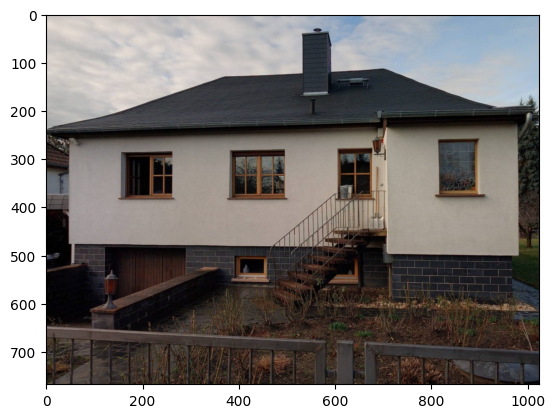

In [26]:
# on example image
yaw, hfov, pitch = get_camera_parameters(example_wall["outside_bounding_box"], dict_camera_ids[example_wall["camera_id_for_image"]])

# put params in dict to include in request
params = {
    "yaw": str(yaw),
    "hfov": str(hfov),
    "pitch": str(pitch)
}

request_url = global_base_url + 'Render/' + example_wall["camera_id_for_image"] + '/?apiKey=' + cyclo_api_key + '&srsName=' + gk_srs

if params:
    for key, value in params.items():
        request_url = request_url + '&' + key + '=' + value

response = requests.get(url=request_url, auth=auth)

if response.status_code == 200:
    with open(example_image_path, 'wb') as file:
        file.write(response.content)
    example_image = img.imread(example_image_path)
    plt.imshow(example_image)
    plt.show()
else:
    print(response.status_code)

### Compute image coordinates for all corners of wall from real-world wall coordinates

In [18]:
def world_coordinates_to_image(point_to_find, meta_data, ground_level_z = None):
    ''' 
    Converts world coordinates of a point to image coordinates based on camera metadata.

    This function takes a 3D point in world coordinates and transforms it into 2D image coordinates 
    using the camera's position, orientation, and focal length provided in the metadata. 
    If a ground level z-coordinate is provided, it adjusts the camera's height accordingly.

    PARAMS:
    *point_to_find: A 3d tuple representing the 3D coordinates of the point to be projected.
    *meta_data: A dictionary containing camera metadata, including recording location and focal length.
    *ground_level_z: (Optional) A float representing the ground level z-coordinate of the building to adjust the camera height.

    RESULTS:
    *x_image: The x-coordinate in the image space (in pixels).
    *y_image: The y-coordinate in the image space (in pixels).
    
    Returns None for both x_image and y_image if the computed coordinates are out of the image bounds.
    '''

    # coordinates of camera
    camera_coords = np.array([meta_data["RecordingLocation-X"], meta_data["RecordingLocation-Y"], meta_data["RecordingLocation-Z"]], dtype = float)
    # if ground level z is given, the z-position (height) is corrected to be the ground-z-value of the building + 2.09 (height of camera from street) as sometimes the z coordinates are off (or the building z coordinates are off) up to a meter
    if ground_level_z is not None:
        camera_coords[2] = float(ground_level_z) + camera_height

    # focal length can be computed, but is also already in meta data (and fx = fy, so both will be f)
    f = float(meta_data["Render-FocalLength"])
    #fx = int(meta_data["Render-width"]) / (2 * np.tan(np.radians(float(meta_data["Render-HFov"]))/2))
    #fy = int(meta_data["Render-height"]) / (2 * np.tan(np.radians(float(meta_data["Render-VFov"]))/2))

    # rotation matrix consists of rotation for pitch (around x axis) and yaw (around z)
    R_pitch = np.array(
        [[1,0,0],
        [ 0, np.cos(np.radians(float(meta_data["Render-Pitch"]))), np.sin(np.radians(float(meta_data["Render-Pitch"])))],
        [ 0, - np.sin(np.radians(float(meta_data["Render-Pitch"]))), np.cos(np.radians(float(meta_data["Render-Pitch"])))]]
    )
    
    R_yaw = np.array(
        [[ np.cos(np.radians(float(meta_data["Render-Yaw"]))), - np.sin(np.radians(float(meta_data["Render-Yaw"]))), 0],
        [ np.sin(np.radians(float(meta_data["Render-Yaw"]))), np.cos(np.radians(float(meta_data["Render-Yaw"]))), 0],
        [ 0, 0, 1]]
    )

    # combine (order important!)
    R = np.dot(R_pitch, R_yaw)

    # translate point to find by camera coords and rotate with R
    P_camera = np.dot(R, np.array(point_to_find - camera_coords).reshape(-1, 1))

    # funny thing happens here: normally, the z-axis in a camera coordinate system is supposed to point forwards (here the north-facing y-axis does that, so P_camera[1,0]), the x-axis should point to the right (thats the case here, x points into east direction) and y-axis should point down (what z is doing in our case, only that z is going up, so its minus P_camera[2,0]) 
    P_x = P_camera[0,0]
    P_y = -P_camera[2,0]
    P_z = P_camera[1,0]

    # finish computing x and y in image: with focal length and rotated coordinates and size of images: get image coordinates
    x_image = int((f * P_x) / P_z) + int(meta_data["Render-width"])/2 # fx instead of f here, if fx!=fy
    y_image = int((f * P_y) / P_z) + int(meta_data["Render-height"])/2 # fy instead of f here, if fx!=fy

    # check if they are inside the image or at least not too far out of them
    valid_coordinates = True

    # if coordinates are too far out, image can not be used
    if x_image < -100 or x_image >= int(meta_data["Render-width"]) + 100:
        #print("Warning: x is not in the image. x is:", x_image)
        valid_coordinates = False

    if y_image < -100 or y_image >= int(meta_data["Render-height"]) + 100:
        #print("Warning: y is not in the image. y is:", y_image)
        valid_coordinates = False
    
    if not valid_coordinates:
        return None, None

    return x_image, y_image


def print_points_at_coordinates(array_with_x_and_y, image_path):
    ''' 
    Plots red points at specified coordinates on a given image and plots both

    PARAMS:
    *array_with_x_and_y: A 2D array-like structure where each row contains the x and y coordinates of a point to be plotted.
    *image_path: A string representing the file path to the image on which the points will be plotted.
    '''

    # Read image in
    image = img.imread(image_path)

    # show image
    plt.imshow(image)
    plt.scatter(array_with_x_and_y[:,0], array_with_x_and_y[:,1], color = "red", s = 10)
    plt.show()


def print_surfaces_at_coordinates(surface, image):
    ''' 
    Plots a surface defined by a set of coordinates on a given image as frame and plots both

    PARAMS:
    * surface: A 2D array-like structure where each row contains the x and y coordinates of points defining the surface.
    * image: An array representing the image on which the surface will be plotted (height, width, channels)
    '''
    surface = np.array(surface)
    # show image
    plt.imshow(image)
    plt.plot(surface[:,0], surface[:,1], color = "red")
    plt.show()

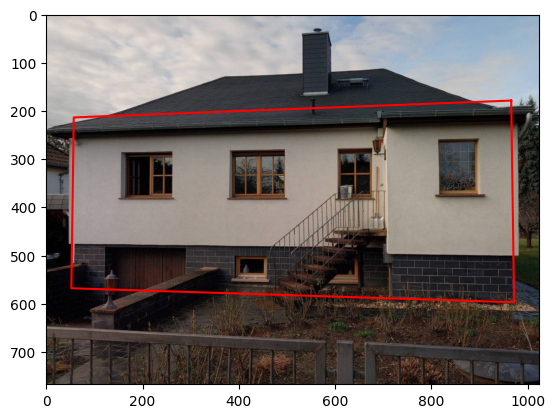

In [ ]:
# get outside surface (wall that should be recognized in the end) and bounding box (only used for rectificatoin)
wall = np.array(example_wall["outside_surface_coordinates"])[0]
bounding_box = np.array(example_wall["outside_bounding_box"])

# project outside surface onto image
outside_surface_in_img = []
for coordinate in wall:
    coordinate = np.array(coordinate)
    x_image, y_image = world_coordinates_to_image(coordinate, response.headers, ground_level_z=np.min([wall[:,2]]))
    outside_surface_in_img.append([x_image, y_image])

# project bounding box onto image
if np.all(bounding_box == wall):
    bounding_box_in_img = outside_surface_in_img
else:
    bounding_box_in_img = []
    for coordinate in bounding_box:
        coordinate = np.array(coordinate)
        x_image, y_image = world_coordinates_to_image(coordinate, response.headers, ground_level_z=np.min([bounding_box[:,2]]))
        bounding_box_in_img.append([x_image, y_image])

 # Read image in and plot outside surface (mostly similar to bounding box if its a rectangle anyway)
image = img.imread(example_image_path)
print_surfaces_at_coordinates(np.array(outside_surface_in_img), image)

### Rectify wall

In [19]:
def rectify_image(temp_img, bounding_box_3d, bounding_box_in_image, outside_surface_in_image, img_width, img_height, dist_to_img_border = 25):
    ''' 
    Rectifies an image based on a 3D bounding box and its corresponding 2D projection.

    This function performs a perspective transformation on the input image to align it with a specified 3D bounding box. It calculates the destination points based on the dimensions of the bounding box and the image size, ensuring a specified distance from 
    the image borders. The function also transforms the coordinates of an outside surface based on the same perspective transformation.

    PARAMS:
    * temp_img: An array representing the image to be rectified.
    * bounding_box_3d: A list of tuples, the 3D coordinates of the bounding box.
    * bounding_box_in_image: A list of tuples, the 2D coordinates of the bounding box in the image.
    * outside_surface_in_image: A list of tuples representing the coordinates of an outside surface in the image.
    * img_width: An integer representing the width of the output rectified image.
    * img_height: An integer representing the height of the output rectified image.
    * dist_to_img_border: (Optional) An integer specifying the distance to maintain from the image borders.

    RESULTS:
    * rectified_image: the rectified image after the perspective transformation
    * transformed_outside_surface_in_image: A list of 2d tuples representing the transformed coordinates of the outside surface in the rectified image.

    Returns the rectified image and the transformed outside surface coordinates.
    '''
    # bounding box in 3d
    bounding_box = np.array(bounding_box_3d)
    # source points are the 4 original points in the image used for the perspective transform
    # upper left corner, upper right corner, lower right, lower left
    src_points = np.array([bounding_box_in_image[1], bounding_box_in_image[0], bounding_box_in_image[3], bounding_box_in_image[2]], dtype='float32')

    # get ratio width / height (should stay the same in the outcoming rectified image)
    width = np.linalg.norm(bounding_box[0]-bounding_box[1])
    height = np.linalg.norm(bounding_box[2]-bounding_box[1])

    # check which one is the limiting factor here and adapt destination_points accordingly (always leave a distance to the image border given by dist_to_img_border)
    # destination points are the 4 points that the source points should be transformed to
    if width/height > img_width/img_height:  # width is limiting
        height_in_image = height * (img_width - 2* dist_to_img_border) / width
        dst_points = np.array(
            [[dist_to_img_border,           img_height/2 - height_in_image/2], # upper left
             [img_width-dist_to_img_border, img_height/2 - height_in_image/2], # upper right
             [img_width-dist_to_img_border, img_height/2 + height_in_image/2], # lower right
             [dist_to_img_border,           img_height/2 + height_in_image/2]], # lower left
             dtype='float32'
            )

    else: # height is limiting
        width_in_image = width * (img_height - 2* dist_to_img_border) / height
        dst_points = np.array(
            [[img_width/2 - width_in_image/2, dist_to_img_border], # upper left
             [img_width/2 + width_in_image/2, dist_to_img_border], # upper right
             [img_width/2 + width_in_image/2, img_height-dist_to_img_border], # lower right
             [img_width/2 - width_in_image/2, img_height-dist_to_img_border]]# lower left
            , dtype='float32'
            )
    
    # Compute the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)

    # Apply transformation to image
    rectified_image = cv2.warpPerspective(temp_img, matrix, (img_width, img_height))

    # and to outside_surface
    transformed_outside_surface_in_image = [np.dot(matrix, np.array([x, y, 1], dtype='float32')) for x,y in outside_surface_in_image]
    transformed_outside_surface_in_image = [tuple((point[:2]/point[2]).astype(int).tolist()) for point in transformed_outside_surface_in_image]

    # transformed bounding box not needed anymore
    return rectified_image, transformed_outside_surface_in_image


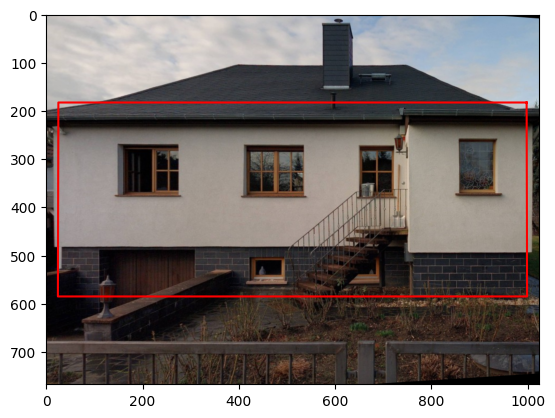

In [44]:
# for example image
rectified_image, transformed_outside_surface_in_image = rectify_image(image, example_wall["outside_bounding_box"], bounding_box_in_img, outside_surface_in_img, img_width, img_height)

print_surfaces_at_coordinates(np.array(transformed_outside_surface_in_image), rectified_image)

## Do all this for all walls
Save rectified image and the outside surface coordinates projected onto the image for each wall where an image could be extracted

In [ ]:
# ca 1500 min for 920000 rows -> 25h
# paths to save temp_img (before its rectified), all images and projected outside surfaces to
temp_img_path = image_dir + "/temp_image.jpg"
rectified_img_dir = image_dir + "/rectified_images"
rectified_img_outside_surfaces_dir = image_dir + "/rectified_walls_outside_surfaces"
imgs_in_dir = os.listdir(rectified_img_dir)

for index, row in df2_walls.iterrows():
    if index % 50000 == 0:
        print(index, "/", len(df2_walls))

    # if image id was found and (rectified) image not extracted and saved yet
    if row["camera_id_for_image"] != "none_found" and row["camera_id_for_image"] != "not_searched_for" and (row["wall_id"] + ".jpg" not in imgs_in_dir):
        # get camera coordinates from id with dictionary
        camera_coords = dict_camera_ids[row["camera_id_for_image"]]
        
        # get parameters
        yaw, hfov, pitch = get_camera_parameters(row["outside_bounding_box"], camera_coords)

        # extract image with render request
        params = {
            "yaw": str(yaw),
            "hfov": str(hfov),
            "pitch": str(pitch)
        }

        request_url = global_base_url + 'Render/' + row["camera_id_for_image"] + '/?apiKey=' + cyclo_api_key + '&srsName=' + gk_srs

        if params:
            for key, value in params.items():
                request_url = request_url + '&' + key + '=' + value

        response = requests.get(url=request_url, auth=auth)

        # if successfull
        if response.status_code == 200:
            # save image
            with open(temp_img_path, 'wb') as file:
                file.write(response.content)
            # read image
            temp_image = img.imread(temp_img_path)
            
            # get outside surface and outside bounding box
            wall = np.array(row["outside_surface_coordinates"])[0]
            bounding_box = np.array(row["outside_bounding_box"])

            # project both into image
            outside_surface_in_img = []
            all_coordinates_in_img = True # +- some pixels
            for coordinate in wall:
                coordinate = np.array(coordinate)
                x_image, y_image = world_coordinates_to_image(coordinate, response.headers)#, ground_level_z=np.min([wall[:,2]]))
                outside_surface_in_img.append([x_image, y_image])
                if x_image is None:
                    all_coordinates_in_img = False

            if bounding_box.shape == wall.shape and np.all(bounding_box == wall):
                bounding_box_in_img = outside_surface_in_img
            else:
                bounding_box_in_img = []
                for coordinate in bounding_box:
                    coordinate = np.array(coordinate)
                    x_image, y_image = world_coordinates_to_image(coordinate, response.headers)#, ground_level_z=np.min([bounding_box[:,2]]))
                    bounding_box_in_img.append([x_image, y_image])

            # if one of the coordinates is not in the image, skip this image, else:
            if all_coordinates_in_img:

                # rectify image and get transformed outside surface coordinates
                rectified_image, transformed_outside_surface_in_image = rectify_image(temp_image, row["outside_bounding_box"], bounding_box_in_img, outside_surface_in_img, img_width, img_height)

                # save image
                img.imsave(rectified_img_dir + "/" + row["wall_id"] + ".jpg", rectified_image)

                # Save transformed outside surface
                with open(rectified_img_outside_surfaces_dir + '/' + row["wall_id"] + '.pkl', 'wb') as f:
                    pickle.dump(transformed_outside_surface_in_image, f)            



0 / 921482
50000 / 921482
100000 / 921482
150000 / 921482
200000 / 921482
250000 / 921482
300000 / 921482
350000 / 921482
400000 / 921482
450000 / 921482
500000 / 921482
550000 / 921482
600000 / 921482
650000 / 921482
700000 / 921482
750000 / 921482
800000 / 921482
850000 / 921482
900000 / 921482


In [ ]:
# show exemplary rectified images and their outside surface projected to image
imgs_in_dir = os.listdir(rectified_img_dir)
counter = 0
for img_path in imgs_in_dir:

    wall_id = img_path.split(".jpg")[0]
    # get image and surface coordinates
    image = img.imread(rectified_img_dir + "/" + img_path)
    with open(rectified_img_outside_surfaces_dir + '/' + wall_id + '.pkl', 'rb') as f:
        surface_coords_in_img = pickle.load(f)  

    print_surfaces_at_coordinates(surface_coords_in_img, image)  

    if counter == 10:
        break
    counter += 1

# out of license reasons, not executed and shown